In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import signal
import glob
import os
import copy
import hera_sim as hs
from scipy import stats




from pyuvdata import UVData, UVBeam, utils as uvutils
import hera_pspec as hp
import hera_cal as hc
import healpy

plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)
path='/home/ntsikelelo/Simulated_data_files/'

## Load required metadata

In [14]:
model = hc.io.HERAData('/net/sinatra/vault-ike/ntsikelelo/Simulated_data_files/UVH5_files/Model_data_incomplete.uvh5')
antpos, ants = model.get_ENU_antpos()
antpos_d = dict(zip(ants, antpos))
N=0
times = np.unique(model.time_array)
model.read(times=times[N:N+2])

model.inflate_by_redundancy()
model.conjugate_bls()
model._determine_blt_slicing()
model._determine_pol_indexing()
model.x_orientation = 'east'

bl_lens = {bl: np.linalg.norm(antpos_d[bl[1]]-antpos_d[bl[0]]) for bl in model.get_antpairs()}   
# downselect to maximum baseline length (to reduce computational load in calibration)
bls = []
for bl in list(model.get_antpairs()):
    # max 40 m baseline cut (also cut autos)
    bl_len = np.linalg.norm(antpos_d[bl[1]] - antpos_d[bl[0]])
    if bl_len > 0:
        bls.append(bl[:2])   
model.select(bls=bls)
model_data, _, _ = model.build_datacontainers()

## baseline cut comparison 

In [15]:

n_bls=0
total_bls=0
for k in model_data:
    total_bls+=1
    blvec = (antpos[k[0]] - antpos[k[1]])
    bl_len_EW = np.abs(blvec[0])

    if bl_len_EW < 30:    
        n_bls+=1
print(total_bls,n_bls)

4095 1835


In [16]:
n_bls=0
total_bls=0
           
for k in model_data:
    total_bls+=1
    blvec = antpos[k[0]] - antpos[k[1]]
#     print(blvec)
    if np.linalg.norm(blvec) < 40:    
         n_bls+=1
print(total_bls,n_bls)

4095 1017


## Chi-square analysis 0.25 mHz filter 

In [23]:
lsts = np.unwrap(model.lsts) * 12/np.pi - 24
N=91
nbl=(N*(N-1))/2.0 
dof=nbl-N
print(np.min(np.where(lsts>=1.25)),np.max(np.where(lsts<=3)))
lst_index=np.array([np.min(np.where(lsts>=1.25)),np.max(np.where(lsts<=3))])

76 180


In [24]:
chisq_complete_unfil=np.load(path+"correct_sigma_chisq_redcal_and_abscal_sky_model_no_filter_complete_no_filter.npy")[lst_index[0]:lst_index[1],:]
chisq_incomplete_unfil_baseline_cut=np.load(path+"correct_sigma_chisq_redcal_and_abscal_sky_model_no_filter_incomplete_no_filter_baseline_cut.npy")[lst_index[0]:lst_index[1],:]
chisq_incomplete_unfil=np.load(path+"correct_sigma_chisq_redcal_and_abscal_sky_model_no_filter_incomplete_no_filter.npy")[lst_index[0]:lst_index[1],:]

chisq_complete_fil_baseline_cut=np.load(path+"correct_sigma_chisq_redcal_and_abscal_sky_model_notch_filter_0.25_dssp_complete_with_filter_baseline_cut.npy")[lst_index[0]:lst_index[1],:]
chisq_complete_fil=np.load(path+"correct_sigma_chisq_redcal_and_abscal_sky_model_notch_filter_0.25_dssp_complete_with_filter.npy")[lst_index[0]:lst_index[1],:]
chisq_incomplete_fil=np.load(path+"correct_sigma_chisq_redcal_and_abscal_sky_model_notch_filter_0.25_dssp_incomplete_with_filter.npy")[lst_index[0]:lst_index[1],:]

chisq_incomplete_fil_baseline_cut=np.load(path+"correct_sigma_chisq_redcal_and_abscal_sky_model_notch_filter_0.25_dssp_incomplete_with_filter_baseline_cut.npy")[lst_index[0]:lst_index[1],:]


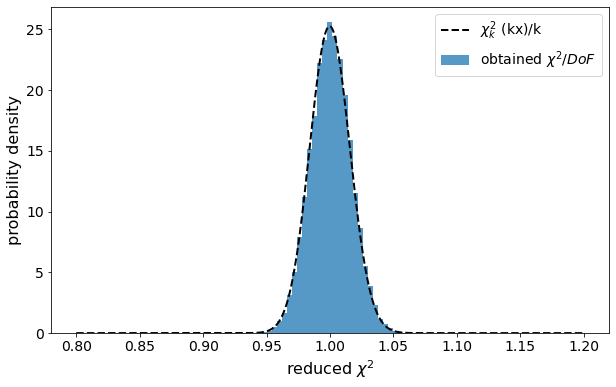

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(np.abs(chisq_complete_unfil.ravel()), bins=101, range=(0.8, 1.2), density=True, alpha=0.75,label="obtained $\chi^2/DoF$")
x = np.linspace(0.8, 1.2, 1000)
plt.plot(x, stats.chi2.pdf(x * 2*dof, 2*dof) * 2*dof, c='k', ls='--', lw=2,label="$\chi_k^2$ (kx)/k ")
plt.xlabel(r'reduced $\chi^2$', fontsize=16)
plt.ylabel('probability density', fontsize=16)
plt.legend()

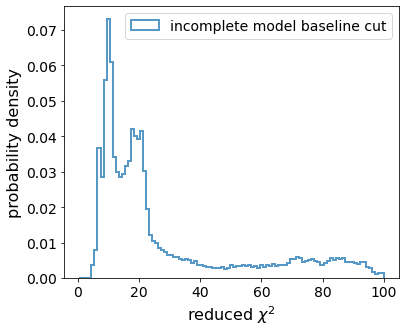

In [26]:
plt.figure(figsize=(6, 5))
plt.hist(np.abs(chisq_incomplete_unfil_baseline_cut.ravel()), bins=101, range=(0.5, 100), density=True, alpha=0.75, label="incomplete model baseline cut",histtype='step',lw=2)
plt.xlabel(r'reduced $\chi^2$', fontsize=16)
plt.ylabel('probability density', fontsize=16)
plt.legend()

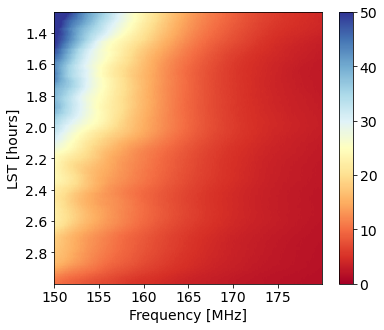

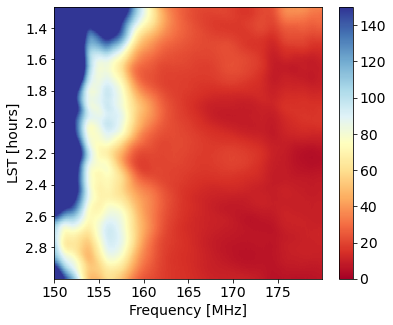

In [27]:
plt.figure(figsize=(6, 5))
plt.imshow(chisq_incomplete_fil, cmap=plt.cm.RdYlBu, vmin=0, vmax=50,extent=[freqs[0], freqs[-1], lsts[lst_index[-1]], lsts[lst_index[0]]], aspect='auto')
plt.colorbar()
plt.ylabel('LST [hours]')
plt.xlabel('Frequency [MHz]')
plt.show()

plt.figure(figsize=(6, 5))
plt.imshow(chisq_incomplete_unfil_baseline_cut, cmap=plt.cm.RdYlBu, vmin=0, vmax=150,extent=[freqs[0], freqs[-1], lsts[lst_index[-1]], lsts[lst_index[0]]], aspect='auto')
plt.colorbar()
plt.ylabel('LST [hours]')
plt.xlabel('Frequency [MHz]')
plt.show()



## ALL Filters at LST~2h

In [32]:
print(np.min(np.where(lsts>=1.95)),np.max(np.where(lsts<=2.1)))
lst_index=np.array([np.min(np.where(lsts>=1.95)),np.max(np.where(lsts<=2.1))])
c0=np.load(path+"correct_sigma_chisq_redcal_and_abscal_sky_model_no_filter_incomplete_no_filter_baseline_cut.npy")[lst_index[0]:lst_index[1],:]
c1=np.load(path+"correct_sigma_chisq_redcal_and_abscal_sky_model_notch_filter_0.25_dssp_incomplete_with_filter_baseline_cut.npy")[lst_index[0]:lst_index[1],:]
c2=np.load(path+"correct_sigma_chisq_redcal_and_abscal_sky_model_notch_filter_0.40_dssp_incomplete_with_filter_baseline_cut.npy")[lst_index[0]:lst_index[1],:]
c3=np.load(path+"correct_sigma_chisq_redcal_and_abscal_sky_model_notch_filter_0.60_dssp_incomplete_with_filter_baseline_cut.npy")[lst_index[0]:lst_index[1],:]
c4=np.load(path+"correct_sigma_chisq_redcal_and_abscal_sky_model_no_filter_incomplete_no_filter.npy")[lst_index[0]:lst_index[1],:]


118 126


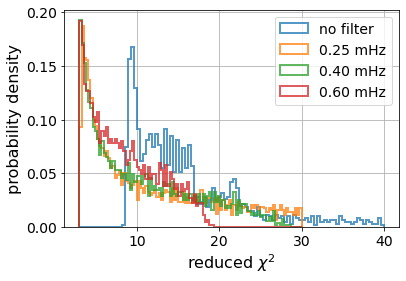

In [34]:
plt.hist(np.abs(c0.ravel()), bins=101, range=(3, 40), density=True, alpha=0.75,label="no filter",histtype='step',lw=2)
plt.hist(np.abs(c1.ravel()), bins=101, range=(3, 30), density=True, alpha=0.75,label="0.25 mHz",histtype='step',lw=2)
plt.hist(np.abs(c2.ravel()), bins=101, range=(3, 30), density=True, alpha=0.75,label="0.40 mHz",histtype='step',lw=2)
plt.hist(np.abs(c3.ravel()), bins=101, range=(3, 30), density=True, alpha=0.75,label="0.60 mHz",histtype='step',lw=2)

plt.xlabel(r'reduced $\chi^2$', fontsize=16)
plt.ylabel('probability density', fontsize=16)
plt.legend()
plt.grid()

In [35]:
m0=np.mean(c0.ravel())
m1=np.mean(c1.ravel())
m2=np.mean(c2.ravel())
m3=np.mean(c3.ravel())
m4=np.mean(c4.ravel())
print("no filter no cut mean = "+str(m4)+" no filter mean = "+str(m0)+", filter 0.25 = "+str(m1)+", filter 0.40 = "+str(m2)+", filter 0.60 = "+str(m3))

no filter no cut mean = 47.95581862990875 no filter mean = 48.10462566751192, filter 0.25 = 12.122683954436138, filter 0.40 = 9.201244204594362, filter 0.60 = 6.514101236627207


## Gains at LST ~ 2h

In [41]:
ant=18
g5=np.load(path+"gains_redcal_and_abscal_no_filter_incomplete_no_filter_baseline_cut.npy")[:,lst_index[0]:lst_index[1],:]
g0=np.load(path+"gains_redcal_and_abscal_no_filter_complete_no_filter.npy")[:,lst_index[0]:lst_index[1],:]
g1=np.load(path+"gains_redcal_and_abscal_no_filter_incomplete_no_filter.npy")[:,lst_index[0]:lst_index[1],:]
g2=np.load(path+"gains_redcal_and_abscal_notch_filter_0.25_dssp_incomplete_with_filter_baseline_cut.npy")[:,lst_index[0]:lst_index[1],:]
g3=np.load(path+"gains_redcal_and_abscal_notch_filter_0.40_dssp_incomplete_with_filter_baseline_cut.npy")[:,lst_index[0]:lst_index[1],:]
g4=np.load(path+"gains_redcal_and_abscal_notch_filter_0.60_dssp_incomplete_with_filter_baseline_cut.npy")[:,lst_index[0]:lst_index[1],:]


Nant=len(model.antenna_names)
tau=np.fft.fftshift(np.fft.fftfreq(len(freqs),np.abs(freqs[1]-freqs[0])))*1e3
index=np.where(tau>0)
tau_pos=tau[index]
window=np.ones(g2.shape)
for ant in range (Nant):
    for t in range (8):
    
        window[ant,t,:] = signal.blackmanharris(len(np.mean(np.abs(g1[18,:,:]),axis=0)))

gain_original_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g0))),axis=0),axis=0)[index]
gain_filter_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g2))),axis=0),axis=0)[index]
gain_no_filter_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g1))),axis=0),axis=0)[index]
gain_no_filter_delay_baseline_cut=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g5))),axis=0),axis=0)[index]
gain_filter_delay_40=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g3))),axis=0),axis=0)[index]
gain_filter_delay_60=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g4))),axis=0),axis=0)[index]



(0.0, 600.0)

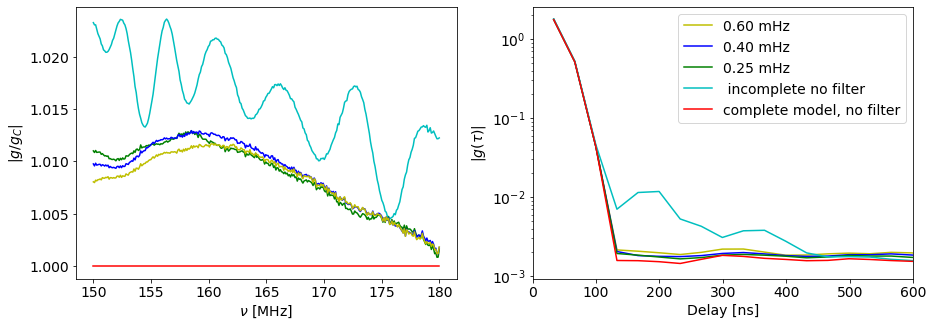

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.subplots_adjust(wspace=0.2)
ax=axes[0]
ant_idx = 18
ax.plot(freqs,np.mean(np.mean(np.abs(g0/g0),axis=0), axis=0),'r',label="true gains")    
ax.plot(freqs, np.mean(np.mean(np.abs(g5/g0),axis=0), axis=0),'c',label="no filter")
ax.plot(freqs, np.mean(np.mean(np.abs(g2/g0),axis=0), axis=0),'g',label="0.25 mHz")
ax.plot(freqs, np.mean(np.mean(np.abs(g3/g0),axis=0), axis=0),'b',label="0.40 mHz")
ax.plot(freqs, np.mean(np.mean(np.abs(g4/g0),axis=0), axis=0),'y',label="0.60 mHz")
ax.set_xlabel("$\\nu$ [MHz]")
ax.set_ylabel("$|g/g_C|$")

ax=axes[1]
ax.semilogy(tau_pos,gain_filter_delay_60,'y',label="0.60 mHz")
ax.semilogy(tau_pos,gain_filter_delay_40,'b',label="0.40 mHz")
ax.semilogy(tau_pos,gain_filter_delay,'g',label="0.25 mHz")
ax.semilogy(tau_pos,gain_no_filter_delay_baseline_cut,'c',label=" incomplete no filter")
ax.semilogy(tau_pos,gain_original_delay,'r',label="complete model, no filter")
ax.set_xlabel("Delay [ns]")
ax.set_ylabel("$|g(\\tau)|$")
ax.legend()
ax.set_xlim(0,600)

In [ ]:
## 

In [43]:

g5=np.load(path+"gains_redcal_and_abscal_no_filter_incomplete_no_filter_baseline_cut.npy")[:,lst_index[0]:lst_index[1],:]
g0=np.load(path+"gains_redcal_and_abscal_no_filter_complete_no_filter.npy")[:,lst_index[0]:lst_index[1],:]
g1=np.load(path+"gains_redcal_and_abscal_no_filter_complete_Gaussian_filter.npy")[:,lst_index[0]:lst_index[1],:]
g2=np.load(path+"gains_redcal_and_abscal_no_filter_incomplete_Gaussian_filter_baseline_cut.npy")[:,lst_index[0]:lst_index[1],:]
g3=np.load(path+"gains_redcal_and_abscal_notch_filter_0.25_dssp_incomplete_with_filter_baseline_cut.npy")[:,lst_index[0]:lst_index[1],:]
g4=np.load(path+"gains_redcal_and_abscal_notch_filter_0.60_dssp_incomplete_with_filter_baseline_cut.npy")[:,lst_index[0]:lst_index[1],:]


Nant=len(model.antenna_names)
tau=np.fft.fftshift(np.fft.fftfreq(len(freqs),np.abs(freqs[1]-freqs[0])))*1e3
index=np.where(tau>0)
tau_pos=tau[index]
window=np.ones(g2.shape)
for ant in range (Nant):
    for t in range (8):
    
        window[ant,t,:] = signal.blackmanharris(len(np.mean(np.abs(g1[18,:,:]),axis=0)))

gain_original_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g0))),axis=0),axis=0)[index]
gain_filter_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g2))),axis=0),axis=0)[index]
gain_no_filter_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g1))),axis=0),axis=0)[index]
gain_no_filter_delay_baseline_cut=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g5))),axis=0),axis=0)[index]
gain_filter_delay_40=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g3))),axis=0),axis=0)[index]
gain_filter_delay_60=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g4))),axis=0),axis=0)[index]

(0.0, 700.0)

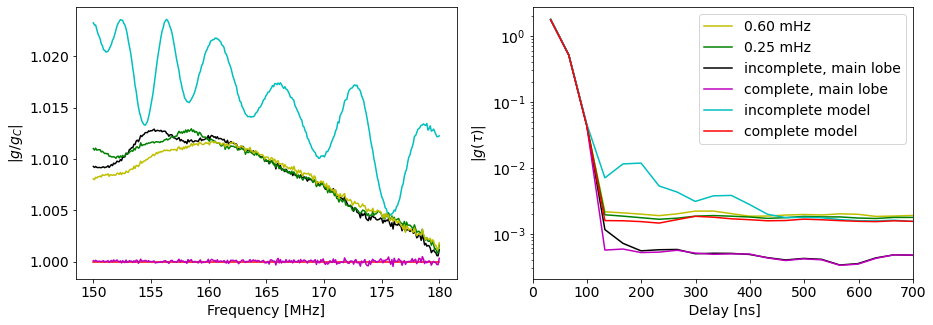

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.subplots_adjust(wspace=0.2)
ax=axes[0]
ant_idx = 18
ax.plot(freqs, np.mean(np.mean(np.abs(g0/g0),axis=0), axis=0),'r')    
ax.plot(freqs, np.mean(np.mean(np.abs(g1/g0),axis=0), axis=0),'m')
ax.plot(freqs, np.mean(np.mean(np.abs(g5/g0),axis=0), axis=0),'c')
ax.plot(freqs, np.mean(np.mean(np.abs(g2/g0),axis=0), axis=0),'k')
ax.plot(freqs, np.mean(np.mean(np.abs(g3/g0),axis=0), axis=0),'g')
ax.plot(freqs, np.mean(np.mean(np.abs(g4/g0),axis=0), axis=0),'y')
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("$|g/g_C|$")


ax=axes[1]
ax.semilogy(tau_pos,gain_filter_delay_60,'y',label="0.60 mHz")
ax.semilogy(tau_pos,gain_filter_delay_40,'g',label="0.25 mHz")
ax.semilogy(tau_pos,gain_filter_delay,'k',label="incomplete, main lobe")
ax.semilogy(tau_pos,gain_no_filter_delay,'m',label="complete, main lobe")
ax.semilogy(tau_pos,gain_no_filter_delay_baseline_cut,'c',label="incomplete model")
ax.semilogy(tau_pos,gain_original_delay,'r',label="complete model")
ax.set_xlabel(" Delay [ns]")
ax.set_ylabel("$|g(\\tau)|$")
ax.legend()
ax.set_xlim(0,700)

## Noise free 

In [47]:
ant=18
g5=np.load(path+"gains_redcal_and_abscal_no_filter_no_noise_incomplete_no_filter_baseline_cut.npy")[:,lst_index[0]:lst_index[1],:]
g0=np.load(path+"gains_redcal_and_abscal_no_filter_no_noise_complete_no_filter.npy")[:,lst_index[0]:lst_index[1],:]
g2=np.load(path+"gains_redcal_and_abscal_no_filter_no_noise_without_notch_incomplete_Gaussian_filter_baseline_cut.npy")[:,lst_index[0]:lst_index[1],:]
g3=np.load(path+"gains_redcal_and_abscal_notch_filter_0.25_dssp_noise_free_incomplete_with_filter_baseline_cut.npy")[:,lst_index[0]:lst_index[1],:]
g4=np.load(path+"gains_redcal_and_abscal_notch_filter_0.60_dssp_noise_free_incomplete_with_filter_baseline_cut.npy")[:,lst_index[0]:lst_index[1],:]



Nant=len(model.antenna_names)
tau=np.fft.fftshift(np.fft.fftfreq(len(freqs),np.abs(freqs[1]-freqs[0])))*1e3
index=np.where(tau>0)
tau_pos=tau[index]
window=np.ones(g2.shape)
for ant in range (Nant):
    for t in range (8):
    
        window[ant,t,:] = signal.blackmanharris(len(np.mean(np.abs(g1[18,:,:]),axis=0)))

gain_original_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g0))),axis=0),axis=0)[index]
gain_filter_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g2))),axis=0),axis=0)[index]
gain_no_filter_delay=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g1))),axis=0),axis=0)[index]
gain_no_filter_delay_baseline_cut=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g5))),axis=0),axis=0)[index]
gain_filter_delay_40=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g3))),axis=0),axis=0)[index]
gain_filter_delay_60=np.mean(np.mean(np.fft.fftshift(np.abs(np.fft.fft(window*g4))),axis=0),axis=0)[index]






(0.0, 1000.0)

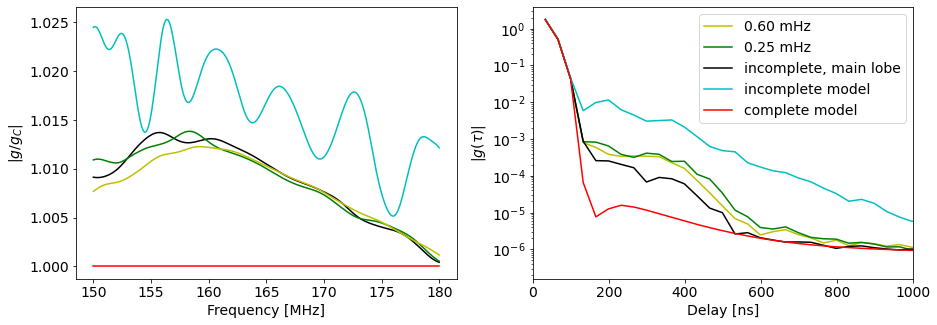

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.subplots_adjust(wspace=0.2)
ax=axes[0]
ant_idx = 18
ax.plot(freqs, np.mean(np.mean(np.abs(g0/g0),axis=0), axis=0),'r')    
ax.plot(freqs, np.mean(np.mean(np.abs(g5/g0),axis=0), axis=0),'c')
ax.plot(freqs, np.mean(np.mean(np.abs(g2/g0),axis=0), axis=0),'k')
ax.plot(freqs, np.mean(np.mean(np.abs(g3/g0),axis=0), axis=0),'g')
ax.plot(freqs, np.mean(np.mean(np.abs(g4/g0),axis=0), axis=0),'y')
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("$|g/g_C|$")


ax=axes[1]
ax.semilogy(tau_pos,gain_filter_delay_60,'y',label="0.60 mHz")
ax.semilogy(tau_pos,gain_filter_delay_40,'g',label="0.25 mHz")
ax.semilogy(tau_pos,gain_filter_delay,'k',label="incomplete, main lobe")
ax.semilogy(tau_pos,gain_no_filter_delay_baseline_cut,'c',label="incomplete model")
ax.semilogy(tau_pos,gain_original_delay,'r',label="complete model")
ax.set_xlabel("Delay [ns]")
ax.set_ylabel("$|g(\\tau)|$")
ax.legend()
ax.set_xlim(0,1000)